In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DF=pd.read_csv('OnlineRetailData.csv')

DF.info()
DF.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
DF = DF[~DF['InvoiceNo'].astype(str).str.startswith('C')]
DF['InvoiceDate'] = pd.to_datetime(DF['InvoiceDate'])


In [8]:
last_date = DF['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = DF.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'UnitPrice': 'MonetaryValue'})

# Check the first few rows
print(rfm.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          1           1.04
12347.0           2        182         481.21
12348.0          75         31         178.71
12349.0          19         73         605.10
12350.0         310         17          65.30


In [9]:
DF = DF.dropna(subset=['CustomerID'])

In [10]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_

# Check the distribution of clusters
print(rfm['Cluster'].value_counts())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
0    2851
2    1054
3     413
4      17
1       4
Name: count, dtype: int64


            Recency    Frequency  MonetaryValue
Cluster                                        
0         45.672746    61.369344     182.498107
1          2.000000  5807.750000   22893.065000
2        249.853890    27.570209      96.214859
3         18.547215   358.472155    1053.288571
4         12.352941  1330.647059    5394.565294


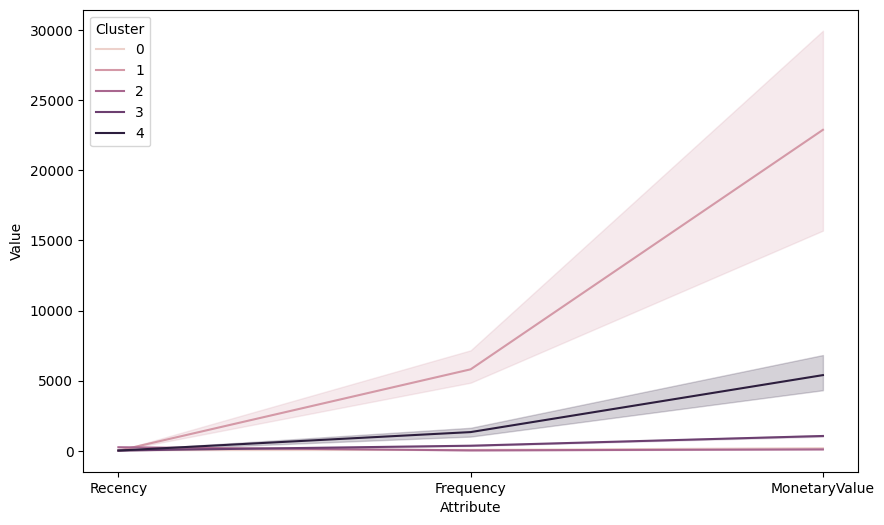

In [13]:
# Calculate the mean RFM values for each cluster
cluster_summary = rfm.groupby('Cluster').mean()
print(cluster_summary)

# Visualize the clusters
rfm_melted = pd.melt(rfm.reset_index(), id_vars=['CustomerID', 'Cluster'], value_vars=['Recency', 'Frequency', 'MonetaryValue'], var_name='Attribute', value_name='Value')
plt.figure(figsize=(10, 6))
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=rfm_melted)
plt.show()

In [17]:
# Assuming df is your cleaned DataFrame
last_date = datetime(2011, 12, 9)

# Recalculate RFM with simplified column names
rfm = DF.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: ((last_date - x.max()).days) / 30),
    Frequency=('InvoiceNo', 'count'),
    MonetaryValue=('UnitPrice', 'sum')  # Adjust according to how you want to calculate Monetary
).reset_index()

# Calculate IQR for Frequency and MonetaryValue
Q1 = rfm[['Frequency', 'MonetaryValue']].quantile(0.25)
Q3 = rfm[['Frequency', 'MonetaryValue']].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
is_not_outlier = ~((rfm[['Frequency', 'MonetaryValue']] < (Q1 - 1.5 * IQR)) | (rfm[['Frequency', 'MonetaryValue']] > (Q3 + 1.5 * IQR))).any(axis=1)
rfm_filtered = rfm[is_not_outlier]

# Normalize the RFM metrics
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_filtered[['Recency', 'Frequency', 'MonetaryValue']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_scaled', 'Frequency_scaled', 'MonetaryValue_scaled'])


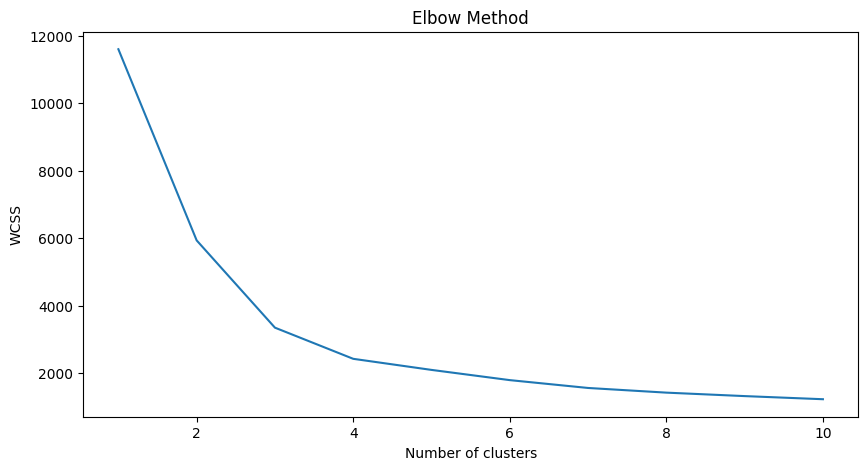

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume rfm_scaled contains your normalized RFM values
rfm_scaled = rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'MonetaryValue_scaled']].to_numpy()

# Calculating WCSS for different numbers of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results on a line graph to observe the 'Elbow'
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


Number of clusters: 2, Silhouette Score: 0.47
Number of clusters: 3, Silhouette Score: 0.47
Number of clusters: 4, Silhouette Score: 0.44
Number of clusters: 5, Silhouette Score: 0.38
Number of clusters: 6, Silhouette Score: 0.36
Number of clusters: 7, Silhouette Score: 0.37
Number of clusters: 8, Silhouette Score: 0.34
Number of clusters: 9, Silhouette Score: 0.33
Number of clusters: 10, Silhouette Score: 0.32


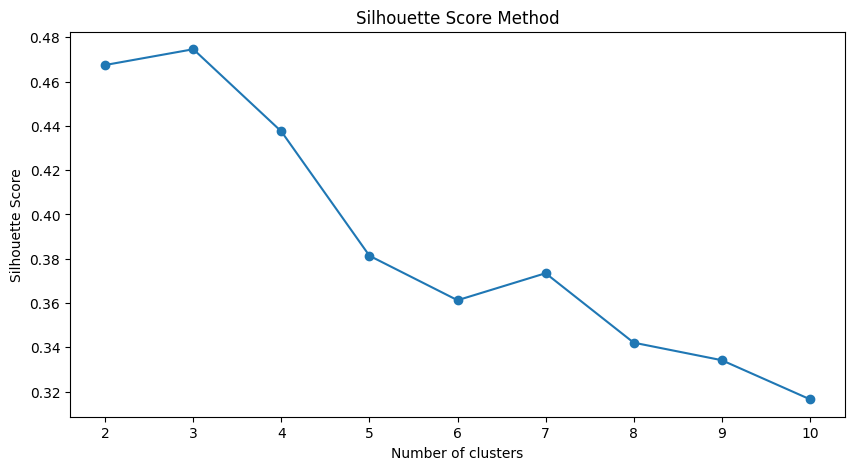

In [19]:
from sklearn.metrics import silhouette_score

# Silhouette score calculation
silhouette_scores = []
for i in range(2, 11):  # silhouette_score is not defined for a single cluster
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"Number of clusters: {i}, Silhouette Score: {score:.2f}")

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [24]:
# Choose the number of clusters as found from the Elbow Method
optimal_clusters = 2

# Applying K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(rfm_scaled)

# Adding cluster labels to the original rfm DataFrame
rfm_filtered['Cluster'] = cluster_labels

# Checking the size of each cluster
print(rfm_filtered['Cluster'].value_counts())

# Analyzing the centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['Recency', 'Frequency', 'MonetaryValue'])
print(centroids)


Cluster
0    2783
1    1083
Name: count, dtype: int64
    Recency   Frequency  MonetaryValue
0  4.068608   26.776420      81.438934
1  1.352829  114.849631     335.930776


/var/folders/ym/0_vtz1kx4_5fl0q9222rj5n40000gn/T/ipykernel_17759/3990554781.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_filtered['Cluster'] = cluster_labels
